In [1]:
import hddCRP.modelFitting
import hddCRP.simulations
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx

In [2]:
Y = np.array([0,1,2] * 2).reshape((2,3)).flatten(order='F')
Y = np.append(Y,Y)
N = Y.size;
grps = np.zeros((N,2),dtype=int)
grps[:6,1] = 1

D = np.ones((N,N))
alphas = [1,2];

print(Y)
print(grps.T)

[0 0 1 1 2 2 0 0 1 1 2 2]
[[0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 0 0 0 0 0 0]]


In [16]:
model = hddCRP.modelFitting.hddCRPModel(Y=Y, groupings=grps, alpha=alphas, D=D)
model._validate_internals("INIT")

In [17]:
codes = model.run_gibbs_sweep(DEBUG_MODE=True)
print(codes)

CB_tables_values 
[ 0  2 -1  1  1]
CB_tables 
[[0 1 2 2 1 1 0 0 2 0 1 1]
 [0 0 4 4 1 1 0 0 3 3 1 1]]
CB_y 
[[ 0  2 -1 -1  2  2  0  0 -1  0  2  2]
 [ 0  0  1  1  2  2  0  0  1  1  2  2]]
CB_ptr 
[[ 9  4  2  2  5 11  0  0  2  6  5 10]
 [ 0  0  3  2  5  5  7  7  9  8 10 10]]
C_table_values 
[ 0  2 -1  1  1  2]
C_tables 
[[0 1 2 2 1 1 0 0 2 0 1 1]
 [0 0 4 4 1 1 0 0 3 3 1 5]]
C_y 
[[ 0  2 -1 -1  2  2  0  0 -1  0  2  2]
 [ 0  0  1  1  2  2  0  0  1  1  2  2]]
C_ptr 
[[ 9  4  2  2  5 11  0  0  2  6  5 10]
 [ 0  0  3  2  5  5  7  7  9  8 10 11]]
Error found with code: 4


ValueError: node 11 in layer 1 points to a different table at node = 11 layer 0!

In [ ]:
model._validate_print_before_and_after()

<function matplotlib.pyplot.show(close=None, block=None)>

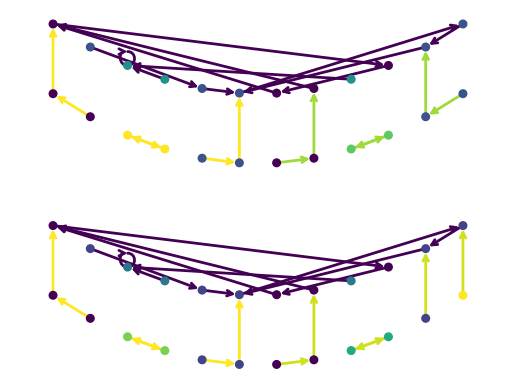

In [18]:


connection_data2= {"C_y" : model._CB_tables, "C_ctx" : grps, "session_lengths" : [model.N], "C_ptr" : model._CB_ptr}
ax2 = plt.subplot(2,1,1)
hddCRP.simulations.make_graph_plot(connection_data2, ax2, hs = 10, hh = 10)
plt.show

connection_data= {"C_y" : model._C_tables, "C_ctx" : grps, "session_lengths" : [model.N], "C_ptr" : model._C_ptr}
ax = plt.subplot(2,1,2)
hddCRP.simulations.make_graph_plot(connection_data, ax, hs = 10, hh = 10)
plt.show


In [ ]:

print(model._CB_num_labeled_upstream.T)
print(model._C_num_labeled_upstream.T)

In [ ]:
print(model._C_is_cycle.T)

In [ ]:
print(model._C_predecessors)

In [ ]:
print(np.sum(model._C_y_0[model._C_tables == 1] != -1))
np.array([np.sum(model._C_y_0[model._C_tables == tt] != -1) 
                                                for tt in range(model._C_table_counter)], dtype=int)